In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load model + data
import joblib

xgb_loaded = joblib.load("models/xgb_calibrated.pkl")
raw_xgb = xgb_loaded.estimator

features = pd.read_csv("data/features_account_level.csv")
X = features.drop(columns=["is_mule","account_id"])
y = features["is_mule"]

probs = raw_xgb.predict_proba(X)[:,1]

/Users/vimu/Documents/Data Science/00 Thesis/Github/aml-mule-risk-scoring/venv/lib/python3.13/site-packages/xgboost/core.py:160: UserWarning: [14:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [2]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

thresholds = np.arange(0.10, 0.95, 0.05)

records = []

for t in thresholds:
    pred = (probs >= t).astype(int)
    
    precision = precision_score(y, pred, zero_division=0)
    recall = recall_score(y, pred, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    alert_volume = pred.mean()   # fraction flagged
    
    records.append({
        "threshold": t,
        "precision": precision,
        "recall": recall,
        "alert_volume": alert_volume,
        "tp": tp, "fp": fp, "fn": fn, "tn": tn
    })

df_thresh = pd.DataFrame(records)
df_thresh

,threshold,precision,recall,alert_volume,tp,fp,fn,tn
0,0.10,0.210361,0.893333,0.1274,134,503,16,4347
1,0.15,0.307339,0.893333,0.0872,134,302,16,4548
2,0.20,0.401813,0.886667,0.0662,133,198,17,4652
3,0.25,0.496241,0.880000,0.0532,132,134,18,4716
4,0.30,0.602740,0.880000,0.0438,132,87,18,4763
5,0.35,0.673469,0.880000,0.0392,132,64,18,4786
6,0.40,0.754286,0.880000,0.0350,132,43,18,4807
7,0.45,0.814815,0.880000,0.0324,132,30,18,4820
8,0.50,0.862745,0.880000,0.0306,132,21,18,4829
9,0.55,0.897260,0.873333,0.0292,131,15,19,4835


In [3]:
FP_COST = 600
FN_COST = 50000

df_thresh["cost"] = df_thresh["fp"] * FP_COST + df_thresh["fn"] * FN_COST
df_thresh

,threshold,precision,recall,alert_volume,tp,fp,fn,tn,cost
0,0.10,0.210361,0.893333,0.1274,134,503,16,4347,1101800
1,0.15,0.307339,0.893333,0.0872,134,302,16,4548,981200
2,0.20,0.401813,0.886667,0.0662,133,198,17,4652,968800
3,0.25,0.496241,0.880000,0.0532,132,134,18,4716,980400
4,0.30,0.602740,0.880000,0.0438,132,87,18,4763,952200
5,0.35,0.673469,0.880000,0.0392,132,64,18,4786,938400
6,0.40,0.754286,0.880000,0.0350,132,43,18,4807,925800
7,0.45,0.814815,0.880000,0.0324,132,30,18,4820,918000
8,0.50,0.862745,0.880000,0.0306,132,21,18,4829,912600
9,0.55,0.897260,0.873333,0.0292,131,15,19,4835,959000


In [4]:
df_thresh.to_csv("data/threshold_cost_analysis.csv", index=False)
print("Saved → data/threshold_cost_analysis.csv")

Saved → data/threshold_cost_analysis.csv


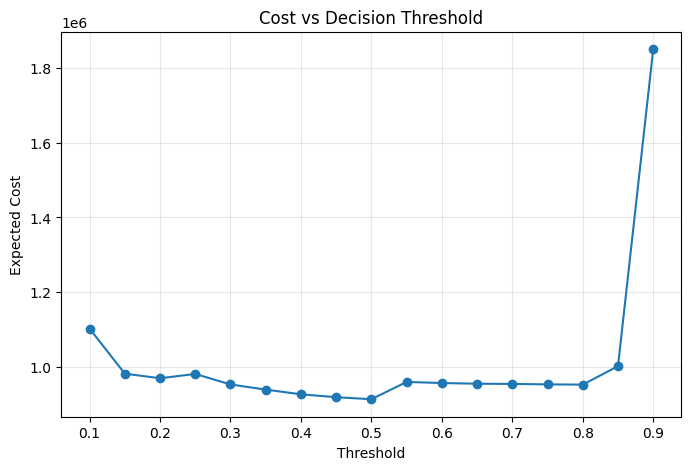

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_thresh["threshold"], df_thresh["cost"], marker="o")
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost vs Decision Threshold")
plt.grid(True, alpha=0.3)

# SAVE FIRST
plt.savefig("figures/cost_vs_threshold.png", dpi=300, bbox_inches="tight")

# THEN SHOW
plt.show()

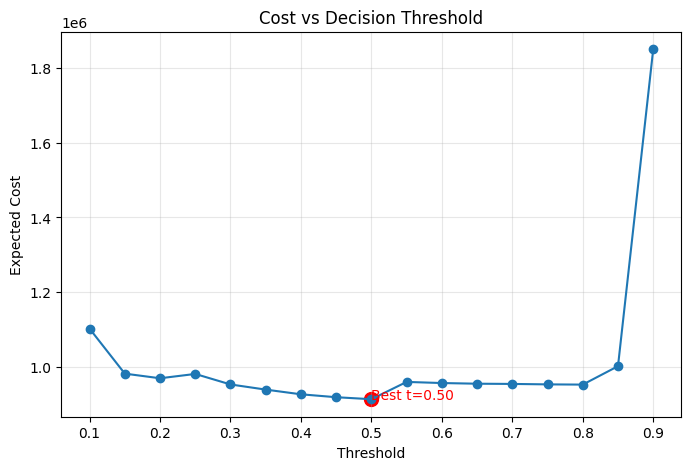

In [7]:
best_row = df_thresh.loc[df_thresh["cost"].idxmin()]

plt.figure(figsize=(8,5))
plt.plot(df_thresh["threshold"], df_thresh["cost"], marker="o")
plt.scatter(best_row["threshold"], best_row["cost"], color="red", s=100)
plt.text(best_row["threshold"], best_row["cost"],
         f"Best t={best_row['threshold']:.2f}", color="red")

plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost vs Decision Threshold")
plt.grid(True, alpha=0.3)

plt.savefig("figures/cost_vs_threshold.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
best_row = df_thresh.loc[df_thresh["cost"].idxmin()]
best_t = float(best_row["threshold"])
best_cost = float(best_row["cost"])

print("Best threshold:", best_t)
print("Expected cost:", best_cost)

Best threshold: 0.5000000000000001
Expected cost: 912600.0


In [10]:
with open("data/best_threshold.txt", "w") as f:
    f.write(f"Best threshold = {best_t:.2f}\nExpected cost = {best_cost:,.0f}")

In [11]:
pd.DataFrame([{"threshold": best_t, "expected_cost": best_cost}]) \
  .to_csv("data/best_threshold_summary.csv", index=False)